# Image Classification

This notebook includes an image classification model that predicts which brain tumor type (meningioma, glioma, pituitary) the image sample represents.

**Dataset Source**

Original creators: Cheng, J. (2017). *Brain tumor dataset* (Version 5) [Dataset]. Figshare. https://doi.org/10.6084/m9.figshare.1512427.v5

Kaggle dataset: https://www.kaggle.com/datasets/denizkavi1/brain-tumor

# Downloading Data

In [ ]:
import os
from dotenv import load_dotenv
from kaggle.api.kaggle_api_extended import KaggleApi

load_dotenv() 

api = KaggleApi()
api.authenticate()

# api.dataset_download_files("denizkavi1/brain-tumor")

Dataset URL: https://www.kaggle.com/datasets/denizkavi1/brain-tumor


# Packages

In [30]:
import os 

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [31]:
device = "mps" if torch.mps.is_available() else "cpu"

print(device)

mps


# Load Images

In [34]:
image_path = []
image_labels = []

parent_file = "brain-tumor-images"

for label in os.listdir(f"{parent_file}"):
    for image in os.listdir(f"{parent_file}/{label}"):
        image_path.append(f"{parent_file}/{label}/{image}")
        image_labels.append(label)

data = pd.DataFrame(
    zip(image_path, image_labels),
    columns=['image_path', 'image_label']
)

data.head()

,image_path,image_label
0,brain-tumor-images/pituitary/1804.png,pituitary
1,brain-tumor-images/pituitary/1810.png,pituitary
2,brain-tumor-images/pituitary/1838.png,pituitary
3,brain-tumor-images/pituitary/1623.png,pituitary
4,brain-tumor-images/pituitary/1637.png,pituitary


In [35]:
tumour_list = data['image_label'].unique().tolist()
print(f"Unique brain tumour labels : {tumour_list}")

Unique brain tumour labels : ['pituitary', 'glioma', 'meningioma']


# Visualisation

These images have 4 channels


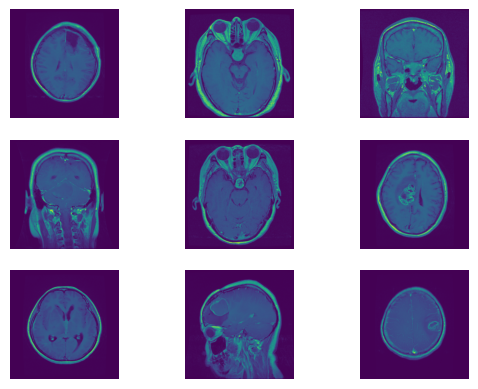

In [36]:
n = 3

fig, axes = plt.subplots(n, n)

for row in range(n):
    for col in range(n):
        image = Image.open(data.sample(1)['image_path'].iloc[0])
        axes[row, col].imshow(image)
        axes[row, col].axis('off')

print(f"These images have {len(image.getbands())} channels")

# Splitting Data

In [37]:
data['image_label'].value_counts()

image_label
glioma        1426
pituitary      930
meningioma     708
Name: count, dtype: int64

In [38]:
glioma_sample = data.query('image_label == "glioma"').sample(708)
pituitary_sample = data.query('image_label == "pituitary"').sample(708)
meningioma_sample = data.query('image_label == "meningioma"')

df = pd.concat([glioma_sample, pituitary_sample, meningioma_sample], axis=0)

df['image_label'].value_counts()

image_label
glioma        708
pituitary     708
meningioma    708
Name: count, dtype: int64

In [39]:
# Let 70% of the data to be training data and the remaining be test/validation data
train_images = df.sample(frac=0.75)
test_val_images = df.drop(train_images.index)

# Let 33% of the test data be validation data
val_images = test_val_images.sample(frac=0.33)
test_images = test_val_images.drop(val_images.index)

In [40]:
# Understanding the shape of each dataset
print(
    df.shape,
    train_images.shape,
    test_images.shape,
    val_images.shape,
    sep='\n'
)

(2124, 2)
(1593, 2)
(356, 2)
(175, 2)


# Data Preprocessing

## Encoding Categorical Data

In [41]:
encoder = LabelEncoder()
encoder.fit(df['image_label'])

for tumour, tumour_code in zip(tumour_list, encoder.transform(tumour_list)):
    print(f"{tumour} = {tumour_code}")

pituitary = 2
glioma = 0
meningioma = 1


## Image Transformation

In [42]:
image_transform = transforms.Compose(
    [
        # Change image size 
        transforms.Resize([128, 128]), # Height, Width

        # Convert image pixels to tensor
        transforms.ToTensor(),

        # Convert data to torch float datatype
        transforms.ConvertImageDtype(torch.float)
    ]
)

In [43]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(encoder.transform(dataframe['image_label'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index, 0]  # Get image path 
        label = self.labels[index]  # Get image label
        image = Image.open(image_path).convert("RGB")  # Get image and ensure it has three channels 

        # Transform image
        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [44]:
train_tensor = ImageDataset(dataframe=train_images, transform=image_transform)
test_tensor = ImageDataset(dataframe=test_images, transform=image_transform)
val_tensor = ImageDataset(dataframe=val_images, transform=image_transform)

In [45]:
print(
    f"Number of training images: {train_tensor.__len__()}",
    f"Image at index two: {train_tensor.__getitem__(2)[0]}",
    f"Image label at index two: {train_tensor.__getitem__(2)[1]} ({encoder.inverse_transform([train_tensor.__getitem__(2)[1].item()])})",
    sep='\n\n'
)

Number of training images: 1593

Image at index two: tensor([[[0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
         [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
         [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
         ...,
         [0.2667, 0.2667, 0.2667,  ..., 0.2706, 0.2706, 0.2706],
         [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667],
         [0.2667, 0.2667, 0.2667,  ..., 0.2667, 0.2667, 0.2667]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0118, 0.0078,  ..., 0.0157, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0157],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.3294, 0.3294, 0.3294,  ..., 0.3294, 0.3294, 0.3294],
         [0.3294, 0.3294, 0.3294,  ..., 0.3333, 0.3333, 0.3333],
     

# Image Classification PyTorch Model

In [46]:
class ImageClassification(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialising convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pooling = nn.MaxPool2d(2, 2)

        # Activation function 
        self.relu = nn.ReLU()

        # Flatten image 
        self.flatten = nn.Flatten()

        # Output goes through neural layer
        self.linear = nn.Linear(
            in_features=(128*16*16), # 128 channels of 16x16 features
            out_features=128
        )

        self.output = nn.Linear(128, len(df['image_label'].unique()))


    def forward(self, x):

        # Increases the number of image features (does not change the image size)
        x = self.conv1(x)       # (32, 128, 128)

        # Reduced the image size (does not change number of features)
        x = self.pooling(x)     # (32, 64, 64)

        # Activation function
        x = self.relu(x)

        x = self.conv2(x)       # (64, 64, 64)
        x = self.pooling(x)     # (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x)       # (128, 32, 32)
        x = self.pooling(x)     # (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

In [47]:
class_model = ImageClassification()

In [48]:
from torchinfo import summary

summary(class_model, input_size=(1, 3, 128, 128)) # Batch size, Channels, Height, Width

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassification                      [1, 3]                    --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─MaxPool2d: 1-2                         [1, 32, 64, 64]           --
├─ReLU: 1-3                              [1, 32, 64, 64]           --
├─Conv2d: 1-4                            [1, 64, 64, 64]           18,496
├─MaxPool2d: 1-5                         [1, 64, 32, 32]           --
├─ReLU: 1-6                              [1, 64, 32, 32]           --
├─Conv2d: 1-7                            [1, 128, 32, 32]          73,856
├─MaxPool2d: 1-8                         [1, 128, 16, 16]          --
├─ReLU: 1-9                              [1, 128, 16, 16]          --
├─Flatten: 1-10                          [1, 32768]                --
├─Linear: 1-11                           [1, 128]                  4,194,432
├─Linear: 1-12                           [1, 3]                    38

# Training & Validation

In [49]:
# Hyperparameters
lr = 1e-5
n_batch = 16
epochs = 25

# Loss criterion
loss_criterion = nn.CrossEntropyLoss()

# Optimise weights in neural network
optimiser = Adam(class_model.parameters(), lr=lr)

# Move model to GPU
class_model.to(device)

ImageClassification(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [50]:
# Load images
train_loader = DataLoader(train_tensor, batch_size=n_batch, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=n_batch, shuffle=True)

In [51]:
training_loss_per_epoch = []
validation_loss_per_epoch = []
training_accuracy_per_epoch = []
validation_accuracy_per_epoch = []

for epoch in range(epochs):
    training_loss = 0.0
    training_accuracy = 0
    validation_loss = 0.0
    validation_accuracy = 0

    # Training
    class_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset optimiser 
        optimiser.zero_grad()

        # Pass inputs into the model
        predictions = class_model(inputs)

        # Calculate training loss
        train_loss = loss_criterion(predictions, labels)
        training_loss += train_loss.item() 

        # Backpropagation
        train_loss.backward()

        # Training accuracy
        train_correct_predictions = (torch.argmax(predictions, dim=1) == labels).sum().item()
        training_accuracy += train_correct_predictions

        # Improve model 
        optimiser.step()


    # Validation
    class_model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = class_model(inputs)

            # Validation loss
            validation_loss += loss_criterion(predictions, labels).item()

            # Validation accuracy
            val_correct_predictions = (torch.argmax(predictions, dim=1) == labels).sum().item()
            validation_accuracy += val_correct_predictions


    # Loss
    training_loss_per_epoch.append(training_loss)
    validation_loss_per_epoch.append(validation_loss)

    # Accuracy
    train_accuracy = round((training_accuracy / train_tensor.__len__()) * 100, 3)
    val_accuracy = round((validation_accuracy / val_tensor.__len__()) * 100, 3)

    training_accuracy_per_epoch.append(train_accuracy)
    validation_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} of {epochs} completed")
    print(f"Training accuracy: {train_accuracy}")
    print(f"Validation accuracy: {val_accuracy}")
    print(f"Training loss: {training_loss}")
    print(f"Validation loss: {validation_loss}\n\n")

Epoch 1 of 25 completed
Training accuracy: 54.802
Validation accuracy: 55.429
Training loss: 104.64263278245926
Validation loss: 10.623112082481384


Epoch 2 of 25 completed
Training accuracy: 66.29
Validation accuracy: 76.0
Training loss: 85.88937735557556
Validation loss: 8.18292486667633


Epoch 3 of 25 completed
Training accuracy: 67.922
Validation accuracy: 74.286
Training loss: 73.75503623485565
Validation loss: 7.325199007987976


Epoch 4 of 25 completed
Training accuracy: 72.63
Validation accuracy: 75.429
Training loss: 67.60834643244743
Validation loss: 6.8016074895858765


Epoch 5 of 25 completed
Training accuracy: 72.693
Validation accuracy: 77.714
Training loss: 63.444829881191254
Validation loss: 6.340613931417465


Epoch 6 of 25 completed
Training accuracy: 75.392
Validation accuracy: 71.429
Training loss: 59.87123915553093
Validation loss: 6.3791157603263855


Epoch 7 of 25 completed
Training accuracy: 77.276
Validation accuracy: 77.714
Training loss: 57.029573917388916


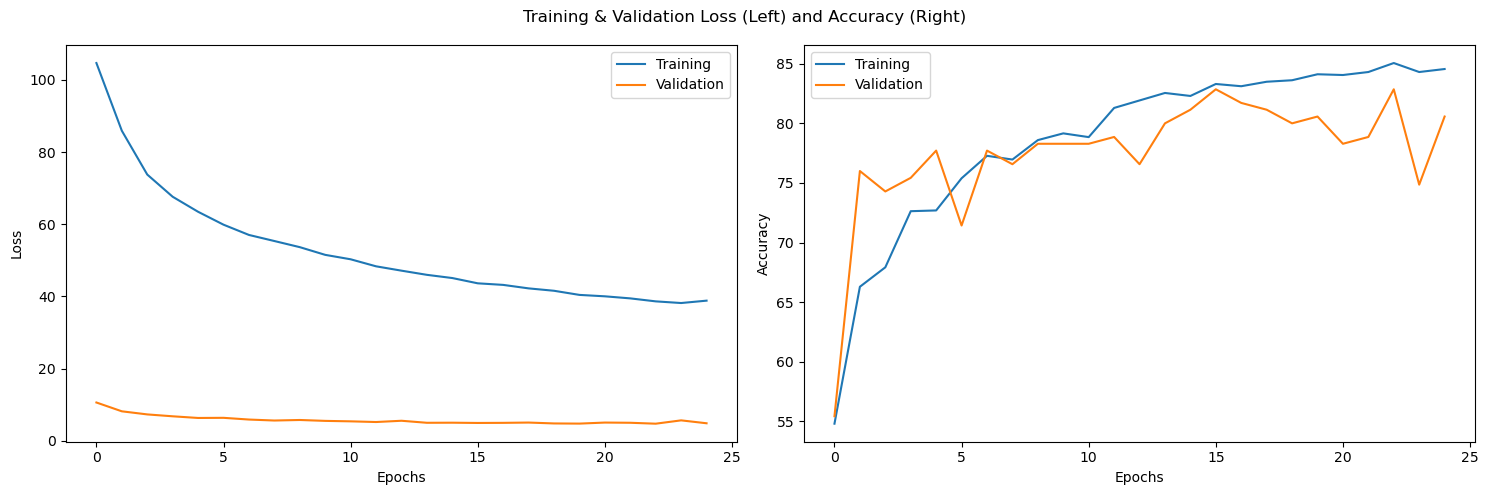

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(training_loss_per_epoch, label='Training')
axes[0].plot(validation_loss_per_epoch, label='Validation')
axes[0].set(xlabel='Epochs', ylabel='Loss')
axes[0].legend()

axes[1].plot(training_accuracy_per_epoch, label='Training')
axes[1].plot(validation_accuracy_per_epoch, label='Validation')
axes[1].set(xlabel='Epochs', ylabel='Accuracy')
axes[1].legend()

plt.suptitle("Training & Validation Loss (Left) and Accuracy (Right)")
plt.tight_layout()

# Testing

In [53]:
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0

    for input, label in test_loader:
        prediction = class_model(input)

        correct_predictions = (torch.argmax(prediction, axis=1) == label).sum().item()
        test_accuracy += correct_predictions

        loss = loss_criterion(prediction, label)
        test_loss += loss.item()

total_test_accuracy = round(((test_accuracy / test_images.__len__()) * 100), 3)

print(
    f"Test Accuracy: {total_test_accuracy}%",
    f"Test Loss: {test_loss}",
    sep='\n'
)

Test Accuracy: 83.427%
Test Loss: 9.544385239481926


# Inference

**Image Source**

Kaplan. (2023, January). *Brain cancer detection - MRI images dataset* (Open source dataset). Roboflow. https://universe.roboflow.com/kaplan/brain-cancer-detection-mri-images

In [57]:
image_g = Image.open("inference-image-g.jpg").convert("RGB")    # Glioma

image_g = image_transform(image_g).to(device)

prediction = class_model(image_g.unsqueeze(0))
predicted_encoded_label = torch.argmax(prediction, dim=1).item()
predicted_label = encoder.inverse_transform([[predicted_encoded_label]]).item()

predicted_label

/opt/anaconda3/envs/projects/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:161: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'meningioma'

In [56]:
image_p = Image.open("inference-image-p.jpg").convert("RGB")    # Pituitary

image_p = image_transform(image_p).to(device)

prediction = class_model(image_p.unsqueeze(0))
predicted_encoded_label = torch.argmax(prediction, dim=1).item()
predicted_label = encoder.inverse_transform([[predicted_encoded_label]]).item()

predicted_label

/opt/anaconda3/envs/projects/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:161: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'pituitary'